In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder , StandardScaler
import matplotlib.pyplot as plt

fichier_excel = 'dataset.xlsx'
# Charger le fichier Excel dans un DataFrame
df = pd.read_excel(fichier_excel)
print(df.head().to_string(index=False))

     Patient ID  Patient age quantile SARS-Cov-2 exam result  Patient addmited to regular ward (1=yes, 0=no)  Patient addmited to semi-intensive unit (1=yes, 0=no)  Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  Mean corpuscular volume (MCV)  Monocytes  Red blood cell distribution width (RDW)  Serum Glucose Respiratory Syncytial Virus  Influenza A  Influenza B Parainfluenza 1 CoronavirusNL63 Rhinovirus/Enterovirus  Mycoplasma pneumoniae Coronavirus HKU1 Parainfluenza 3 Chlamydophila pneumoniae   Adenovirus Parainfluenza 4 Coronavirus229E CoronavirusOC43 Inf A H1N1 2009 Bordetella pertussis Metapneumovirus Parainfluenza 2  Neutrophils     Urea  Proteina C reativa mg/dL  Creatinine  Potassium   Sodium Influenza B, rapid test Influenza A, rapid test  Alanine transaminase  Asp

In [20]:
#recalculer les valeurs manquantes 
valeurs_manquantes = df.isna().sum()/df.shape[0]
sang = list(df.columns[(valeurs_manquantes < 0.9) & (valeurs_manquantes >0.88)])
virus = list(df.columns[(valeurs_manquantes < 0.80) & (valeurs_manquantes > 0.75)])

#on ne garde que les variables qui nous intéressent et qui sont des variables utiles 
colonnes = ['Patient age quantile', 'SARS-Cov-2 exam result']
df = df[colonnes + sang + virus]

In [21]:
#on divise notre dataset pour extraire un ensemble de test et un ensemble d'entrainnement 
from sklearn.model_selection import train_test_split
traitement , test = train_test_split(df, test_size=0.2 , random_state=0)
traitement['SARS-Cov-2 exam result'].value_counts()


SARS-Cov-2 exam result
negative    4068
positive     447
Name: count, dtype: int64

In [22]:
def encodage_string(df):
    code = {'negative':0,'positive':1,'not_detected':0,'detected':1}
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
        
    return df

In [23]:
def nettoyage_initial(df):
    # Suppression des colonnes inutiles 
    df=df.drop('Patient ID', axis=1)
    df=df.drop('Influenza A, rapid test', axis=1)
    df=df.drop('Influenza B, rapid test', axis=1)
    return df


In [24]:
def supprimer_colonnes(df, seuil=0.80):
    # Calculer le pourcentage de valeurs manquantes pour chaque colonne
    pourcentage = df.isna().sum() / df.shape[0]
    
    # Filtrer et supprimer les colonnes avec plus de 95% de valeurs manquantes
    columns_to_drop = pourcentage[pourcentage > seuil].index
    df = df.drop(columns=columns_to_drop)
    
    return df

In [25]:
#supprime toutes les lignes (axis=0) qui contiennent des valeurs manquantes (NaN) dans n'importe quelle colonne
def supprimer_nan(df):
    df = df.dropna(axis=0)
    return  df

In [26]:
# Informations sur les colonnes
df.info()

# Statistiques descriptives
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 33 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient age quantile                              5644 non-null   int64  
 1   SARS-Cov-2 exam result                            5644 non-null   object 
 2   Hematocrit                                        603 non-null    float64
 3   Hemoglobin                                        603 non-null    float64
 4   Platelets                                         602 non-null    float64
 5   Mean platelet volume                              599 non-null    float64
 6   Red blood Cells                                   602 non-null    float64
 7   Lymphocytes                                       602 non-null    float64
 8   Mean corpuscular hemoglobin concentration (MCHC)  602 non-null    float64
 9   Leukocytes         

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW)
count,5644.000000,6.030000e+02,6.030000e+02,6.020000e+02,5.990000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.010000e+02,6.020000e+02
mean,9.318391,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,-3.453010e-09,7.206147e-09,-4.155369e-09,-3.220114e-09,1.020433e-08
std,5.777903,1.000830e+00,1.000830e+00,1.000832e+00,1.000836e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000833e+00,1.000832e+00
min,0.000000,-4.501420e+00,-4.345603e+00,-2.552426e+00,-2.457575e+00,-3.970608e+00,-1.865070e+00,-5.431808e+00,-2.020303e+00,-1.140144e+00,-5.937604e+00,-8.355077e-01,-5.101581e+00,-2.163721e+00,-1.598094e+00
25%,4.000000,-5.188074e-01,-5.862439e-01,-6.053457e-01,-6.624832e-01,-5.679496e-01,-7.307069e-01,-5.524761e-01,-6.372547e-01,-5.292256e-01,-5.013556e-01,-6.669502e-01,-5.148128e-01,-6.141920e-01,-6.250727e-01
50%,9.000000,5.340703e-02,4.031596e-02,-1.217160e-01,-1.015171e-01,1.385207e-02,-1.426696e-02,-5.458523e-02,-2.128790e-01,-2.237665e-01,1.259032e-01,-3.298351e-01,6.604462e-02,-1.151911e-01,-1.827903e-01
75%,14.000000,7.171751e-01,7.295320e-01,5.314981e-01,6.838353e-01,6.661759e-01,5.976919e-01,6.424628e-01,4.542955e-01,3.871516e-01,5.963475e-01,3.443949e-01,6.268712e-01,4.888627e-01,3.479481e-01
max,19.000000,2.662704e+00,2.671868e+00,9.532034e+00,3.713052e+00,3.645706e+00,3.764100e+00,3.331071e+00,4.522042e+00,1.107822e+01,4.098546e+00,8.350876e+00,3.410980e+00,4.533397e+00,6.982184e+00


In [27]:
def pretraitement(df):
    df = encodage_string(df)
    df = supprimer_nan(df)
    a = df.drop('SARS-Cov-2 exam result', axis=1)
    b = df['SARS-Cov-2 exam result']
    print(b.value_counts())
    return a, b

La fonction train_test_split est utilisée pour diviser les données en ensembles d'entraînement (X_train, y_train) et de test (X_test, y_test).

On a choisi RandomForestClassifier comme premier algorithme avec lequel on va travailler .

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = encodage_string(df)
df = supprimer_nan(df)

# Sélectionner les caractéristiques (features) et la variable cible 
X = df.drop(columns=['SARS-Cov-2 exam result'])
y = df['SARS-Cov-2 exam result']


# Convertir la variable cible en type catégoriel 
if y.dtype != 'category':
    y = y.astype('category')


# diviser les données en ensembles d'entraînement (X_train, y_train) et de test (X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Créer un objet StandardScaler (standardisation)
scaler = StandardScaler()

# Appliquer la standardisation sur l'ensemble d'entraînement
entrainement = scaler.fit_transform(X_train)

# Appliquer la même transformation sur l'ensemble de test
test = scaler.transform(X_test)

# Créer un classificateur de forêt aléatoire
model = RandomForestClassifier(random_state=0)

# Entrainement du modèle sur l'ensemble d'apprentissage
model.fit(entrainement, y_train)

# prédictions sur l'ensemble de test
y_pred = model.predict(test)

# Évaluation de la performance du modèle en utilisant différentes métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8356164383561644
Precision: 0.8633995755354041
Recall: 0.8356164383561644
F1 Score: 0.7815595363540568


In [29]:
from sklearn.model_selection import cross_val_score

# Utilisation de la validation croisée pour évaluer le modèle
cv_scores = cross_val_score(model, entrainement, y_train, cv=5, scoring='accuracy')

print("Cross-validated accuracy scores:", cv_scores)
print("Mean cross-validated accuracy:", cv_scores.mean())

Cross-validated accuracy scores: [0.89655172 0.89655172 0.9137931  0.86206897 0.89473684]
Mean cross-validated accuracy: 0.8927404718693284


In [30]:
from sklearn.model_selection import GridSearchCV

# les hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialiser le modèle
model = RandomForestClassifier(random_state=0)

# Initialiser la recherche en grille
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Ajuster le modèle sur les données d'entraînement
grid_search.fit(entrainement, y_train)

# Afficher les meilleurs paramètres et la meilleure précision
print("Meilleurs paramètres:", grid_search.best_params_)
print("meilleure cross-validated accuracy:", grid_search.best_score_)


Meilleurs paramètres: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
meilleure cross-validated accuracy: 0.8996370235934664


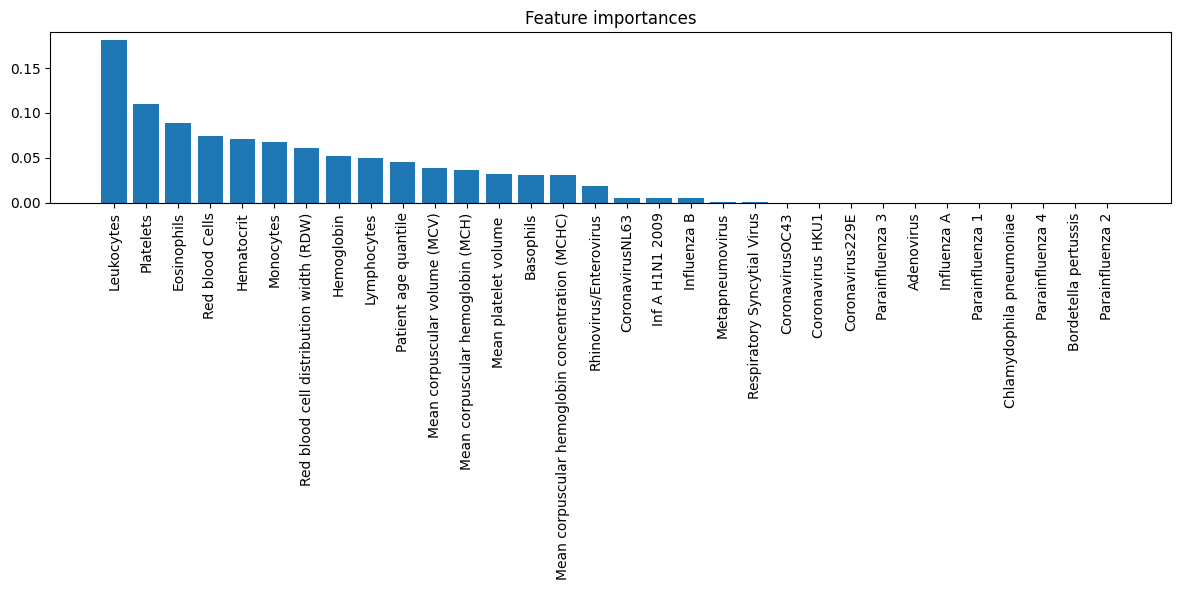

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Entraîner le modèle final avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_
best_model.fit(entrainement, y_train)

# l'importance des caractéristiques
feature_importances = best_model.feature_importances_

# Tri des caractéristiques par importance
indices = np.argsort(feature_importances)[::-1]

# Afficher les importances des caractéristiques
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


Cet histograme confirme l'hypothèse qu'on a définie au début de l'analyse des données, on voit que les tests sanguins ont une importance significatives , contrairement aux tests viraux  ils ont tous moins de 2% d'importance. 
Donc ce qu'on va faire dans la suite, on va filtrer les caractéristiques selon leurs pourcentage d'importance pour avoir une meilleure prédiction.

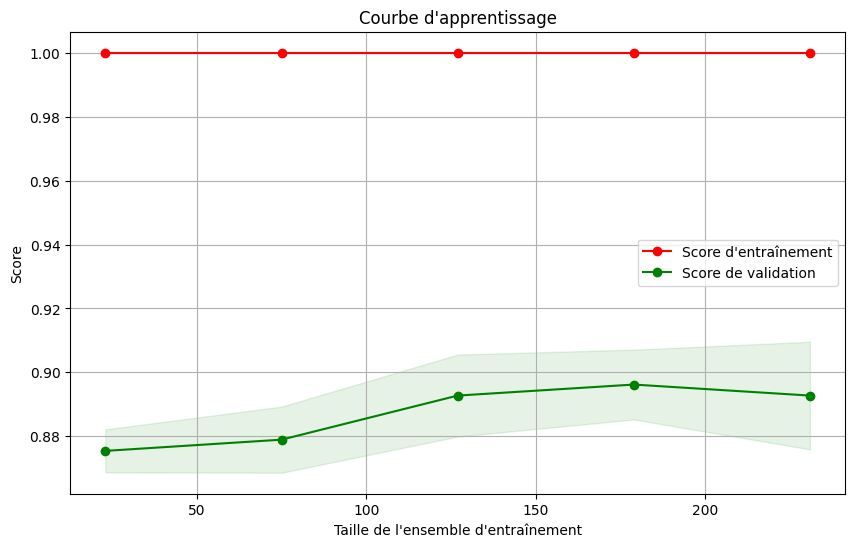

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
#fonction qui affiche la courbe
def plot_learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Courbe d'apprentissage")
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation")

    plt.legend(loc="best")
    plt.show()

plot_learning_curve(model, X_train, y_train)


On remarque que notre modèle est à 100% pour l'ensemble d'entrainnement et 89% d'occurence pour les test, c'est un bon résultats mais le modèle est en overfitting car il y a une différence remarquable entre les deux courbes.
On va donc essayer d'autres algorithmes en modifiant les paramètres pour avoir un résultat meilleur 

Nouveau modèle avec les variables importantes
Accuracy: 0.8904109589041096
Precision: 0.9031169346833433
Recall: 0.8904109589041096
F1 Score: 0.8663856691253952


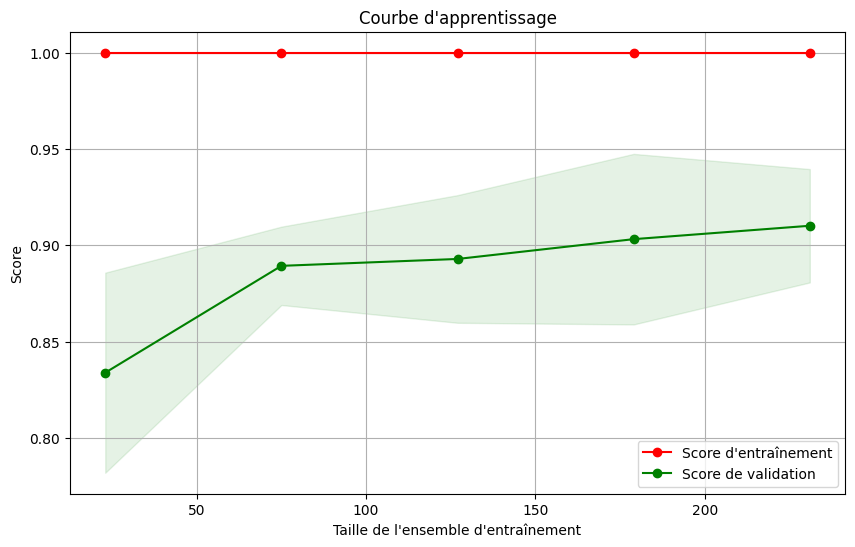

In [33]:
# 1 Calculer les importances des caractéristiques et stocker-les dans un DataFrame
importances_df = pd.DataFrame(feature_importances, index=X_train.columns, columns=['Importance'])

# 2 Filtrer les caractéristiques importantes en fonction du seuil défini
threshold = 0.07
important_features = importances_df[importances_df['Importance'] > threshold].index

# 3 Créer un nouveau jeu de données avec les caractéristiques importantes
X_important = X[important_features]

# 4 Diviser les données en ensembles d'entraînement et de test
X_train_imp, X_test_imp, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

# 5 Standardiser les nouvelles données
X_train_imp_scaled = scaler.fit_transform(X_train_imp)
X_test_imp_scaled = scaler.transform(X_test_imp)

# 6 Ré-entraîner le modèle avec les caractéristiques importantes
model_imp = RandomForestClassifier(random_state=42)
model_imp.fit(X_train_imp_scaled, y_train)

# 7 Faire des prédictions sur l'ensemble de test
y_pred_imp = model_imp.predict(X_test_imp_scaled)

# 8 Évaluer les performances du modèle ré-entraîné
accuracy_imp = accuracy_score(y_test, y_pred_imp)
precision_imp = precision_score(y_test, y_pred_imp, average='weighted')
recall_imp = recall_score(y_test, y_pred_imp, average='weighted')
f1_imp = f1_score(y_test, y_pred_imp, average='weighted')

print("Nouveau modèle avec les variables importantes")
print("Accuracy:", accuracy_imp)
print("Precision:", precision_imp)
print("Recall:", recall_imp)
print("F1 Score:", f1_imp)
plot_learning_curve(model_imp, X_train_imp_scaled, y_train)


Après avoir testé plusieurs valeurs pour le seuil d'importance des variables, on a séléctionné que les features avec plus de 0.07 d'imporatnce on a eu un résultat meilleur mais ça reste en overfitting.
On va donc essayer d'autres algorithmes de classification.
On a choisi KNeighborsClassifier et SVM.

SVM Model:
Accuracy: 0.8904109589041096
Precision: 0.9031169346833433
Recall: 0.8904109589041096
F1 Score: 0.8663856691253952

KNN Model:
Accuracy: 0.9178082191780822
Precision: 0.9140682757121112
Recall: 0.9178082191780822
F1 Score: 0.9147350660828346


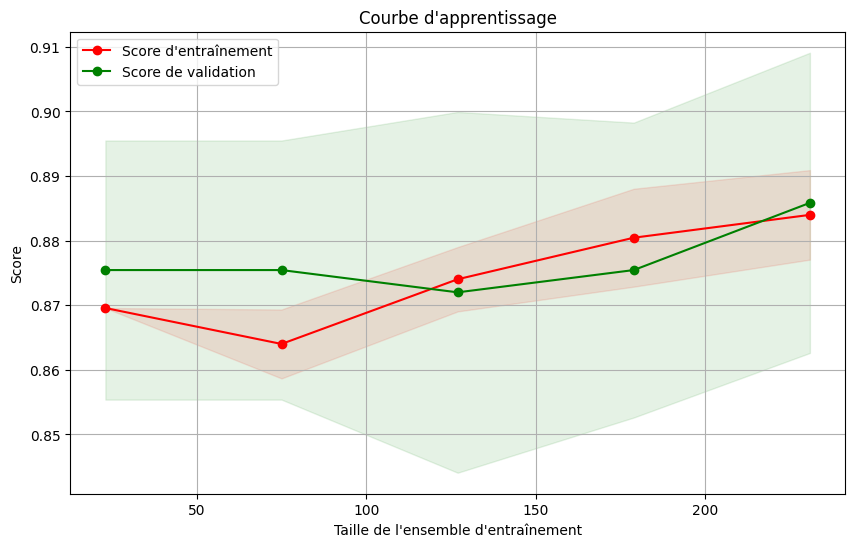

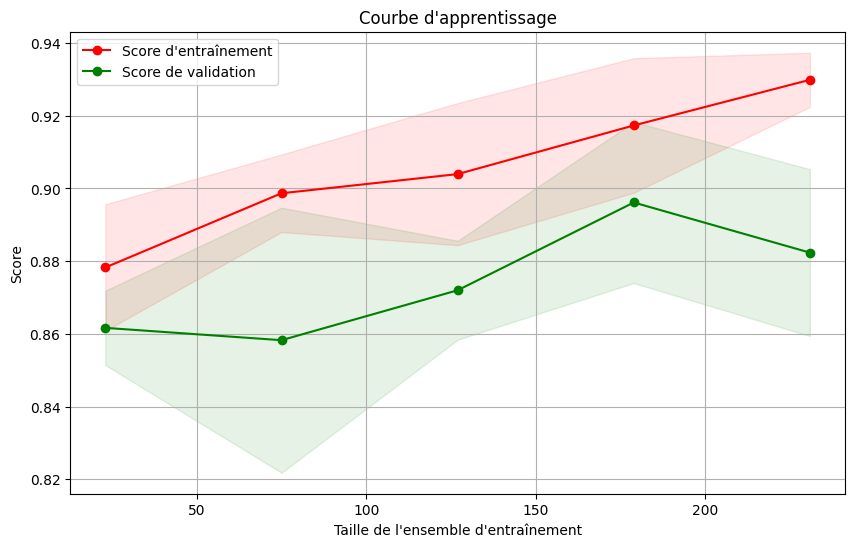

In [34]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Entraîner le modèle SVM
svm_model = SVC()
svm_model.fit(X_train_imp_scaled, y_train)

# Entraîner le modèle KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_imp_scaled, y_train)

# Faire des prédictions avec les modèles
y_pred_svm = svm_model.predict(X_test_imp_scaled)
y_pred_knn = knn_model.predict(X_test_imp_scaled)

# Évaluer les performances des modèles
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print("SVM Model:")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1 Score:", f1_svm)

print("\nKNN Model:")
print("Accuracy:", accuracy_knn)
print("Precision:", precision_knn)
print("Recall:", recall_knn)
print("F1 Score:", f1_knn)

# Affichage des courbes d'apprentissage pour SVM
plot_learning_curve(svm_model, X_train_imp_scaled, y_train)

# Affichage des courbes d'apprentissage pour KNN
plot_learning_curve(knn_model, X_train_imp_scaled, y_train)


On va comparer entre les trois modèles:
1-Random Forest  :
   -Score d'entraînement : très élevé (1.0), ce qui peut indiquer un overfitting.
   -Score de validation : relativement élevé (autour de 0.90), mais il y a un écart entre le score d'entraînement et de validation, suggérant une possible sur-adaptation.

2-SVM :
   -Score d'entraînement : stable et légèrement inférieur au score de validation au début.
   -Score de validation : augmente progressivement avec la taille de l'ensemble d'entraînement et converge avec le score d'entraînement, ce qui est un bon signe de généralisation.

3-KNN :
   -Score d'entraînement: modérément élevé et augmente avec la taille de l'ensemble d'entraînement.
   -Score de validation: augmente de manière constante et se rapproche du score d'entraînement, ce qui indique une bonne généralisation.

Conclusion::

-Random Forest montre un excellent score d'entraînement mais pourrait souffrir d'overfitting en raison de l'écart avec le score de validation.
-SVM a des scores d'entraînement et de validation qui convergent, ce qui suggère une bonne performance générale et une meilleure généralisation que Random Forest.
-KNN montre une progression régulière des scores d'entraînement et de validation, ce qui est bon signe, mais les scores absolus sont légèrement inférieurs à ceux de SVM.
 
 
 
 Meilleur algorithme :
Le SVM  est le meilleur choix parmi les trois, car il offre un bon équilibre entre les scores d'entraînement et de validation, ce qui indique une bonne généralisation sans signes évidents d'overfitting. 